## Description
This is the cross correlation calculation result. The result should show below in the first graph (ignore the other 2). You might need to invoke the cell below here to see the graph.

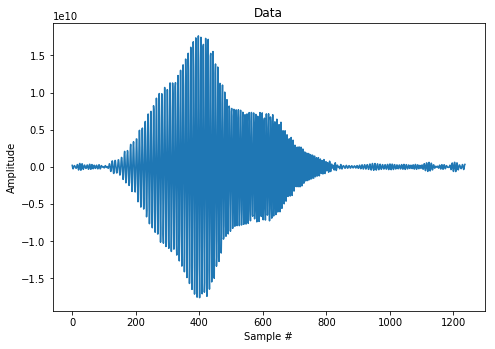

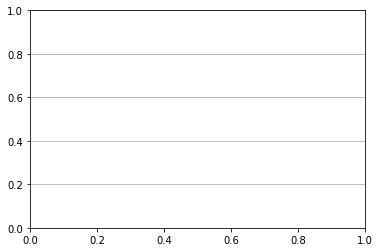

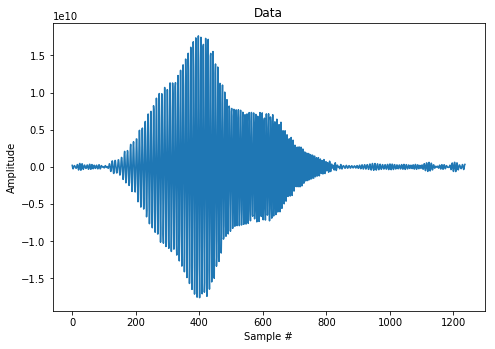

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import analysis
import cross_correlation_analyzer as cca

plt.close('all')
data = cca.main()
analysis.get_graph_figure(data, 'Data')